In [17]:
import $file.sparksession
import sparksession._

Compiling /home/jovyan/work/tfg.dataenergia.scala/notebooks/Spark 2.4.3/sparksession.sc

sparksession.sc:12: could not find implicit value for parameter replApi: ammonite.repl.api.ReplAPI
      .builder()
              ^Compilation Failed

: 

# Lectura JSON

Creamos un DataFrame con el JSON de Balance energético

In [2]:
val balanceDF: DataFrame = spark.read
        .option("multiline","true")
        .json("data/Balance-mes-2023-2024.json")


json at cmd1.sc:3

1 / 1

balanceDF: DataFrame = [data: struct<attributes: struct<description: string, last-update: string ... 1 more field>, id: string ... 2 more fields>, included: array<struct<attributes:struct<content:array<struct<attributes:struct<color:string,composite:boolean,description:string,last-update:string,magnitude:string,title:string,total:double,type:string,values:array<struct<datetime:string,percentage:double,value:double>>>,groupId:string,id:string,type:string>>,description:string,last-update:string,magnitude:string,title:string>,id:string,type:string>>]

In [8]:
val balanceDs: Dataset[Row] = balanceDF

balanceDs: Dataset[Row] = [data: struct<attributes: struct<description: string, last-update: string ... 1 more field>, id: string ... 2 more fields>, included: array<struct<attributes:struct<content:array<struct<attributes:struct<color:string,composite:boolean,description:string,last-update:string,magnitude:string,title:string,total:double,type:string,values:array<struct<datetime:string,percentage:double,value:double>>>,groupId:string,id:string,type:string>>,description:string,last-update:string,magnitude:string,title:string>,id:string,type:string>>]

In [6]:
balanceDF.schema
balanceDF.printSchema

root
 |-- data: struct (nullable = true)
 |    |-- attributes: struct (nullable = true)
 |    |    |-- description: string (nullable = true)
 |    |    |-- last-update: string (nullable = true)
 |    |    |-- title: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- meta: struct (nullable = true)
 |    |    |-- cache-control: struct (nullable = true)
 |    |    |    |-- cache: string (nullable = true)
 |    |    |    |-- expireAt: string (nullable = true)
 |    |-- type: string (nullable = true)
 |-- included: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attributes: struct (nullable = true)
 |    |    |    |-- content: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- attributes: struct (nullable = true)
 |    |    |    |    |    |    |-- color: string (nullable = true)
 |    |    |    |    |    |    |-- composite: boolean (nullable = true)
 |    |    |   

res5_0: StructType = StructType(
  StructField(
    "data",
    StructType(
      StructField(
        "attributes",
        StructType(
          StructField("description", StringType, true, {}),
          StructField("last-update", StringType, true, {}),
          StructField("title", StringType, true, {})
        ),
        true,
        {}
      ),
      StructField("id", StringType, true, {}),
      StructField(
        "meta",
        StructType(
          StructField(
            "cache-control",
            StructType(
              StructField("cache", StringType, true, {}),
              StructField("expireAt", StringType, true, {})
            ),
            true,
            {}
          )
        ),
        true,
        {}
      ),
      StructField("type", StringType, true, {})
    ),
    true,
    {}
  ),
  StructField(
    "included",
    ArrayType(
...

Con explode generamos una columna con una fila por cada elemento del array

Guardar dataframe en un .csv

In [7]:
val familiasEnergiaDF = balanceDF.withColumn("FamiliasEnergia", explode($"included"))
val tiposEnergiaDF = familiasEnergiaDF.withColumn("TiposEnergia", explode($"FamiliasEnergia.attributes.content"))
val valoresEnergiaDF = tiposEnergiaDF.withColumn("Valores", explode($"TiposEnergia.attributes.values"))

familiasEnergiaDF: DataFrame = [data: struct<attributes: struct<description: string, last-update: string ... 1 more field>, id: string ... 2 more fields>, included: array<struct<attributes:struct<content:array<struct<attributes:struct<color:string,composite:boolean,description:string,last-update:string,magnitude:string,title:string,total:double,type:string,values:array<struct<datetime:string,percentage:double,value:double>>>,groupId:string,id:string,type:string>>,description:string,last-update:string,magnitude:string,title:string>,id:string,type:string>> ... 1 more field]
tiposEnergiaDF: DataFrame = [data: struct<attributes: struct<description: string, last-update: string ... 1 more field>, id: string ... 2 more fields>, included: array<struct<attributes:struct<content:array<struct<attributes:struct<color:string,composite:boolean,description:string,last-update:string,magnitude:string,title:string,total:double,type:string,values:array<struct<datetime:string,percentage:double,value:doubl

In [8]:
val valoresEnergia = valoresEnergiaDF.select(
    $"FamiliasEnergia.type".as("FamiliaEnergia"),
    $"TiposEnergia.type".as("TipoEnergia"),
    $"Valores.*"
)


valoresEnergia: DataFrame = [FamiliaEnergia: string, TipoEnergia: string ... 3 more fields]

In [9]:
val valoresEnergiaConFecha = valoresEnergia.withColumn("Fecha", to_date($"datetime")).drop("datetime")

valoresEnergiaConFecha: DataFrame = [FamiliaEnergia: string, TipoEnergia: string ... 3 more fields]

In [10]:
val valoresHidraulica = valoresEnergiaConFecha.filter($"TipoEnergia" === "Hidráulica")
val valoresSolar = valoresEnergiaConFecha.filter($"TipoEnergia" === "Solar fotovoltaica")
val valoresNuclear = valoresEnergiaConFecha.filter($"TipoEnergia" === "Nuclear")
val valoresCarbon = valoresEnergiaConFecha.filter($"TipoEnergia" === "Carbón")
val valoresGas = valoresEnergiaConFecha.filter($"TipoEnergia" === "Ciclo combinado")

valoresHidraulica: Dataset[Row] = [FamiliaEnergia: string, TipoEnergia: string ... 3 more fields]
valoresSolar: Dataset[Row] = [FamiliaEnergia: string, TipoEnergia: string ... 3 more fields]
valoresNuclear: Dataset[Row] = [FamiliaEnergia: string, TipoEnergia: string ... 3 more fields]
valoresCarbon: Dataset[Row] = [FamiliaEnergia: string, TipoEnergia: string ... 3 more fields]
valoresGas: Dataset[Row] = [FamiliaEnergia: string, TipoEnergia: string ... 3 more fields]

In [11]:
valoresEnergiaConFecha.schema

res10: StructType = StructType(
  StructField("FamiliaEnergia", StringType, true, {}),
  StructField("TipoEnergia", StringType, true, {}),
  StructField("percentage", DoubleType, true, {}),
  StructField("value", DoubleType, true, {}),
  StructField("Fecha", DateType, true, {})
)

In [12]:
valoresNuclear.show()

show at cmd11.sc:1

1 / 1

+--------------+-----------+-------------------+-----------+----------+
|FamiliaEnergia|TipoEnergia|         percentage|      value|     Fecha|
+--------------+-----------+-------------------+-----------+----------+
|  No-Renovable|    Nuclear|0.49309305118625113|5086763.589|2023-01-01|
|  No-Renovable|    Nuclear| 0.3882659291256707|4597959.716|2023-02-01|
|  No-Renovable|    Nuclear| 0.4484863613020177|5102291.068|2023-03-01|
|  No-Renovable|    Nuclear| 0.4437513485853026|4567269.056|2023-04-01|
|  No-Renovable|    Nuclear|0.37791174266675187|3741768.391|2023-05-01|
|  No-Renovable|    Nuclear| 0.3486310616228004|4008721.126|2023-06-01|
|  No-Renovable|    Nuclear|0.40169713676631574|5123133.915|2023-07-01|
|  No-Renovable|    Nuclear|0.39481050921417277|5008274.547|2023-08-01|
|  No-Renovable|    Nuclear|  0.375223954077131|4546818.519|2023-09-01|
|  No-Renovable|    Nuclear|0.35630211068419565|3741507.112|2023-10-01|
|  No-Renovable|    Nuclear|0.42962133134992614|3761317.407|2023

# PRUEBA A REPRESNETAR DATOS EN GRAFICOS

Downloaded https://repo1.maven.org/maven2/org/plotly-scala/plotly-almond_2.12/0.7.1/plotly-almond_2.12-0.7.1.pom
Downloaded https://repo1.maven.org/maven2/org/plotly-scala/plotly-core_2.12/0.7.1/plotly-core_2.12-0.7.1.pom
Downloaded https://repo1.maven.org/maven2/org/plotly-scala/plotly-render_2.12/0.7.1/plotly-render_2.12-0.7.1.pom
Downloaded https://repo1.maven.org/maven2/org/webjars/bower/plotly.js/1.41.3/plotly.js-1.41.3.pom
Downloaded https://repo1.maven.org/maven2/org/plotly-scala/plotly-render_2.12/0.7.1/plotly-render_2.12-0.7.1-sources.jar
Downloaded https://repo1.maven.org/maven2/org/webjars/bower/plotly.js/1.41.3/plotly.js-1.41.3-sources.jar
Downloaded https://repo1.maven.org/maven2/org/plotly-scala/plotly-almond_2.12/0.7.1/plotly-almond_2.12-0.7.1.jar
Downloaded https://repo1.maven.org/maven2/org/plotly-scala/plotly-almond_2.12/0.7.1/plotly-almond_2.12-0.7.1-sources.jar
Downloaded https://repo1.maven.org/maven2/org/plotly-scala/plotly-core_2.12/0.7.1/plotly-core_2.12-0.7.1-s

collect at cmd12.sc:6

1 / 1

collect at cmd12.sc:6

64 / 64

collect at cmd12.sc:7

1 / 1

collect at cmd12.sc:7

64 / 64

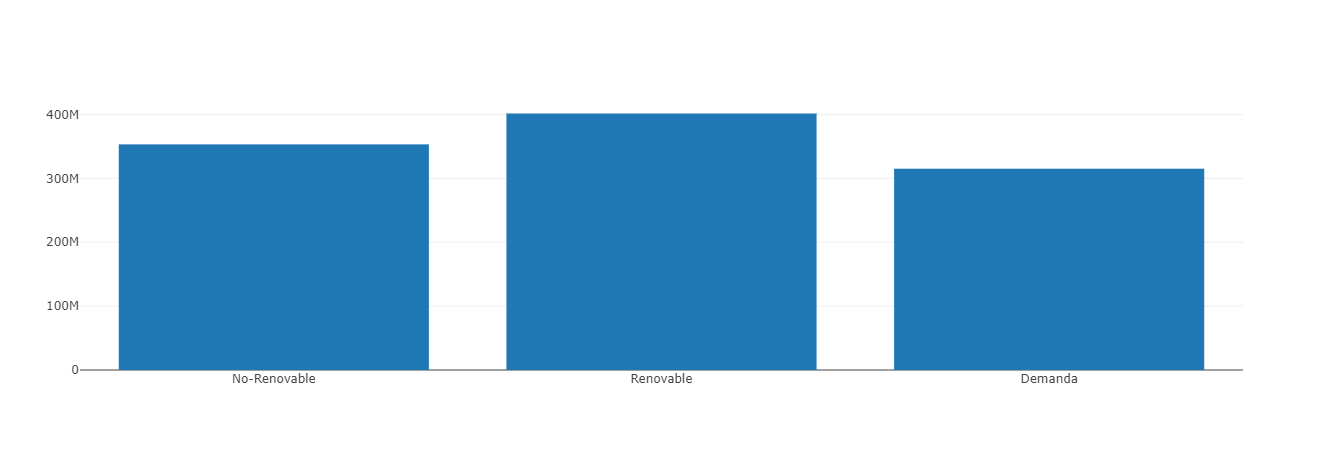

import $ivy.$                                      

import plotly._, plotly.element._, plotly.layout._, plotly.Almond._
//repl.pprinter() = repl.pprinter().copy(defaultHeight = 3)


sumValoresPorFamilia: DataFrame = [FamiliaEnergia: string, TotalValue: double]
FamiliaEnergia: Seq[String] = WrappedArray(
  "No-Renovable",
  "Renovable",
  "Demanda"
)
TotalValue: Seq[Double] = WrappedArray(
  3.533317929920001E8,
  4.0164781302599996E8,
  3.15182985485E8
)
data: Seq[Bar] = List(
  Bar(
    Strings(WrappedArray("No-Renovable", "Renovable", "Demanda")),
    Doubles(
      WrappedArray(3.533317929920001E8, 4.0164781302599996E8, 3.15182985485E8)
    ),
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None
  )
)
res12_6: String = "plot-2b3b3309-9448-4c5c-b501-ca37c2bb8ede"

In [13]:
import $ivy.`org.plotly-scala::plotly-almond:0.7.1`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._
//repl.pprinter() = repl.pprinter().copy(defaultHeight = 3)

val sumValoresPorFamilia = valoresEnergiaConFecha.groupBy($"FamiliaEnergia").agg(sum("value").as("TotalValue"))
val FamiliaEnergia = sumValoresPorFamilia.select($"FamiliaEnergia").as[String].collect.toSeq
val TotalValue = sumValoresPorFamilia.select($"TotalValue").as[Double].collect.toSeq

val data = Seq(
  Bar(
    FamiliaEnergia,
    TotalValue
  )
)

plot(data)

collect at cmd13.sc:1

1 / 1

collect at cmd13.sc:2

1 / 1

collect at cmd13.sc:3

1 / 1

collect at cmd13.sc:4

1 / 1

collect at cmd13.sc:5

1 / 1

collect at cmd13.sc:6

1 / 1

collect at cmd13.sc:7

1 / 1

collect at cmd13.sc:8

1 / 1

collect at cmd13.sc:9

1 / 1

collect at cmd13.sc:10

1 / 1

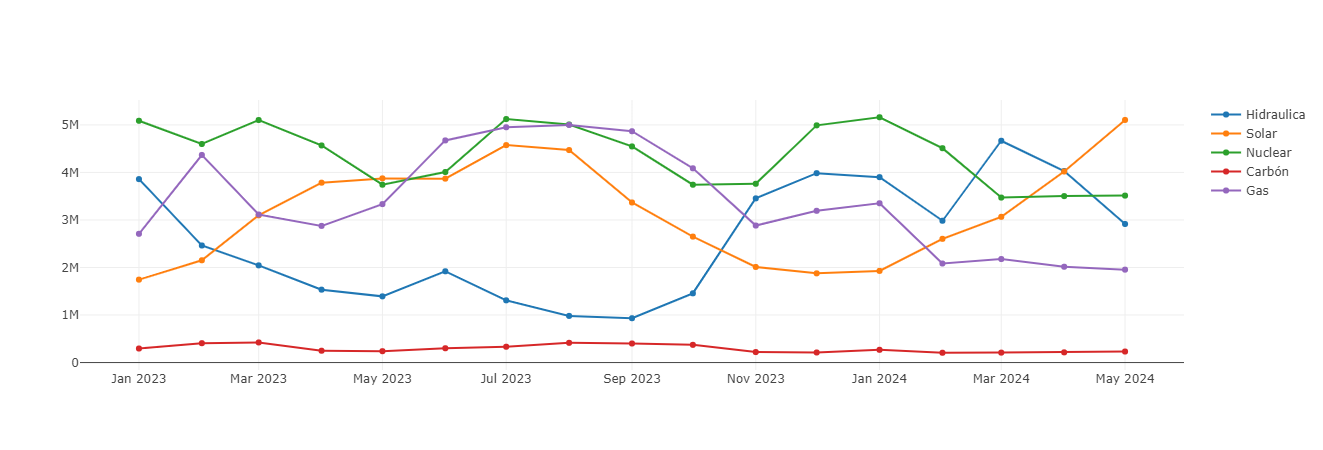

fechaHidraulica: Seq[String] = WrappedArray(
  "2023-01-01",
  "2023-02-01",
  "2023-03-01",
  "2023-04-01",
  "2023-05-01",
  "2023-06-01",
  "2023-07-01",
  "2023-08-01",
  "2023-09-01",
  "2023-10-01",
  "2023-11-01",
  "2023-12-01",
  "2024-01-01",
  "2024-02-01",
  "2024-03-01",
  "2024-04-01",
  "2024-05-01"
)
valorHidraulica: Seq[Double] = WrappedArray(
  3859362.995,
  2462733.917,
  2044472.686,
  1533648.466,
  1392479.121,
  1920006.486,
  1308841.169,
  981141.097,
  932569.994,
  1456377.369,
  3453969.43,
  3984079.747,
  3900610.947,
  2983501.95,
  4666072.453,
  4028823.077,
  2915084.875
)
fechaSolar: Seq[String] = WrappedArray(
  "2023-01-01",
  "2023-02-01",
  "2023-03-01",
  "2023-04-01",
  "2023-05-01",
  "2023-06-01",
  "2023-07-01",
  "2023-08-01",
  "2023-09-01",
  "2023-10-01",
  "2023-11-01",
  "2023-12-01",
  "2024-01-01",
  "2024-02-01",
  "2024-03-01",
  "2024-04-01",
  "2024-05-01"
)
valorSolar: Seq[Double] = WrappedArray(
  1744409.448,
  2151530.691,
  

In [14]:
val fechaHidraulica = valoresHidraulica.select($"Fecha").as[String].collect.toSeq
val valorHidraulica = valoresHidraulica.select($"value").as[Double].collect.toSeq
val fechaSolar = valoresSolar.select($"Fecha").as[String].collect.toSeq
val valorSolar = valoresSolar.select($"value").as[Double].collect.toSeq
val fechaNuclear = valoresNuclear.select($"Fecha").as[String].collect.toSeq
val valorNuclear = valoresNuclear.select($"value").as[Double].collect.toSeq
val fechaCarbon = valoresCarbon.select($"Fecha").as[String].collect.toSeq
val valorCarbon = valoresCarbon.select($"value").as[Double].collect.toSeq
val fechaGas = valoresGas.select($"Fecha").as[String].collect.toSeq
val valorGas = valoresGas.select($"value").as[Double].collect.toSeq

val Hidraulica = Scatter(
    fechaHidraulica,
    valorHidraulica,
    name = "Hidraulica"
)
val Solar = Scatter(
    fechaSolar,
    valorSolar,
    name = "Solar"
)

val Nuclear = Scatter(
    fechaNuclear,
    valorNuclear,
    name = "Nuclear"
)
val Carbon = Scatter(
    fechaCarbon, 
    valorCarbon,
    name = "Carbón"
)
val Gas = Scatter(
    fechaGas,
    valorGas,
    name = "Gas"
)
val data = Seq(Hidraulica,Solar, Nuclear, Carbon, Gas)
plot(data)